In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from netCDF4 import Dataset
import pandas as pd
import properscoring as ps
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import warnings
import xarray as xr
from matplotlib import cm
from utils.evaluation import find_landfalling_tcs,tc_region,create_xarray,get_storm_coords
from utils.metrics import calculate_crps
from global_land_mask import globe
from scipy.interpolate import griddata
from utils.data import load_tc_data
from utils.plot import make_cmap
# from utils.metrics import calculate_fid
import xesmf as xe
import glob
warnings.filterwarnings("ignore")

sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))
sns.set_palette(sns.color_palette("Set2"))

# TODO: check which way the storms are rotating and how this is plotted - if using imshow it won't take into account
# the fact that mswep uses reverse latitude
# TODO: are the accumulated ones being plotted in the right places? like is it in the right order?

In [30]:
def plot_accumulated(data,lats,lons,vmin=0,vmax=200,plot='show',limit=1,cmap='Blues',title=False,levels=[0,50,100,150,200,250,300],centre_lats=None,centre_lons=None,intensity=None,ax=None,mask_oceans=False,cbar=False,cax=False):
        """
        Plots the accumulated rainfall of a tropical cyclone while it's at tropical cyclone strength
        """
        data = np.where(data<limit,np.nan,data)
        lon2d,lat2d = np.meshgrid(lons,lats)
        if plot != 'ax':
                fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
        c = ax.contourf(lon2d,lat2d,data,vmin=vmin,vmax=vmax,levels=levels,cmap = cmap, transform=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
        ax.add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)
        if centre_lats is not None:
                for i in range(len(centre_lats)):
                        if intensity[i] == 0.0:
                                colour = '#ffb600'
                                colour='black'
                        elif intensity[i] == 1.0:
                                colour =  '#ff9e00'
                                colour='black'
                        elif intensity[i] == 2.0:
                                colour = '#ff7900'
                                colour='black'
                        elif intensity[i] == 3.0:       
                                colour = '#ff6000'
                                colour='black'
                        elif intensity[i] == 4.0:
                                colour = '#ff4000' 
                                colour='black'
                        elif intensity[i]==5.0:
                                colour = '#ff2000' 
                                colour='black'
                        ax.plot(centre_lons[i:i+2],centre_lats[i:i+2],color=colour)
        ax.outline_patch.set_linewidth(0.5)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
        gl.xlabels_top = False
        gl.ylabels_right = False
        if plot != 'ax':
                cbar = plt.colorbar(c, shrink=0.78)
                # cbar.outline.set_linewidth(0.5)
                cbar.ax.tick_params(labelsize=6,width=0.5)
        
        if cbar == True:
                precip_cmap,precip_norm = make_cmap(high_vals=True)
                # cbar = plt.colorbar(c,fraction=1.5, pad=-0.7,cmap=precip_cmap,norm=precip_norm,ticks=levels,boundaries=levels, format='%1i',ax=cax)
                cbar = plt.colorbar(c,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',ax=cax)
                # cbar.ax.tick_params(labelsize=8,width=0.5)
                cbar.ax.tick_params(labelsize=14)

        if title != False:
                ax.set_title(title,fontsize=22)

        if plot=='show':
                plt.show()
        elif plot=='save':
                plt.savefig('accumulated_rainfall.png',bbox_inches='tight',dpi=300)
        else:
                return ax

In [3]:
def accumulated_rain(storm,meta,real,pred_gan,inputs,flip=True):
	# grab mswep coordinate variables
	fp = '/bp1store/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
	d = Dataset(fp, 'r')
	lat = d.variables['lat'][:] #lat
	lon = d.variables['lon'][:] #lon
	print('lat shape: ',lat.shape)
	print('lon shape: ',lon.shape)
	# calculate lats and lons for storm
	lats,lons = tc_region(meta,storm,lat,lon)
	# initialise accumulated xarray
	# grid_x, grid_y = np.meshgrid(lats, lons)
	grid_x, grid_y = np.meshgrid(lons,lats)
	# a = np.zeros((grid_x.shape))
	print('grid_x shape: ',grid_x.shape)
	print('grid_y.shape: ', grid_y.shape)
	print('lons shape: ',lons.shape)
	print('lats shape: ',lats.shape)
	a = np.zeros((grid_y.shape))
	print('a shape',a.shape)
	accumulated_ds = create_xarray(lats,lons,a)
	accumulated_ds_pred = create_xarray(lats,lons,a)
	# accumulated_ds_input = create_xarray(lats,lons,a)
	# loop through storm time steps o generate accumulated rainfall
	for i in storm:
		storm_lats,storm_lons = get_storm_coords(lat,lon,meta,i)
		ds = create_xarray(storm_lats,storm_lons,real[i])
		ds_pred = create_xarray(storm_lats,storm_lons,pred_gan[i])
		input_lats,input_lons = get_storm_coords(np.arange(-89.5,90,1),np.arange(-179.5,180),meta,i)
		# ds_input = create_xarray(input_lats,input_lons,inputs[i])

		# if flip==True:
		# 	ds.precipitation.values = np.flip(ds.precipitation.values,axis=0)
		# 	ds_pred.precipitation.values = np.flip(ds_pred.precipitation.values,axis=0)

		# regrid so grids match
		regridder = xe.Regridder(ds, accumulated_ds, "bilinear")
		ds_out = regridder(ds)
		ds_pred_out = regridder(ds_pred)

		# regird the inputs
		# regridder = xe.Regridder(ds_input, accumulated_ds, "bilinear")
		# ds_input_out = regridder(ds_input)

		# add up rainfall
		accumulated_ds = accumulated_ds + ds_out
		accumulated_ds_pred = accumulated_ds_pred + ds_pred_out
		# accumulated_ds_input = accumulated_ds_input + ds_input_out

	return accumulated_ds,accumulated_ds_pred

In [4]:
# define mode
# mode = 'validation'
# mode = 'extreme_valid'
# load datasets
real,inputs,pred_cnn,pred_vaegan,pred_gan,pred_ensemble_vaegan,pred_ensemble_gan,meta = load_tc_data(set='validation',results='test')
real_x,inputs_x,pred_cnn_x,pred_vaegan_x,pred_gan_x,pred_vaegan_ensemble_x,pred_gan_ensemble_x,meta_extreme_valid = load_tc_data(set='extreme_valid',results='test')
# real_extreme_test,inputs_extreme_test,pred_cnn_extreme_test,pred_vaegan_extreme_test,pred_gan_extreme_test,pred_vaegan_ensemble_extreme_test,pred_gan_ensemble_extreme_test,meta_extreme_test = load_tc_data(set='extreme_test',results='test')
# inputs = np.load('/user/home/al18709/work/gan_predictions_20/validation_input-opt_improve.npy')[:,:,:,0]
hrmip = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3p/historical/storm_rain.npy')[-28000:]
tcs = pd.read_csv('/user/work/al18709/ibtracks/tc_files.csv')
# regrid inputs
grid_in = {"lon": np.linspace(0, 100, 10), "lat": np.linspace(0, 100, 10)}
grid_out = {"lon": np.linspace(0, 100, 100), "lat": np.linspace(0, 100, 100)}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
inputs_hr = regridder(inputs)
hrmip_hr = regridder(hrmip)

In [5]:
# get list of landfalling tcs
# landfall_sids = find_landfalling_tcs(meta)
valid_sids = list(dict.fromkeys(meta['sid']))
# get valid sids
# assign sid variable to list of sid indices correspoinnding to storm timesteps
for sid in valid_sids:
	indices = meta.sid[meta.sid == sid].index.tolist()
	exec('sid_%s = indices' % sid)

# get extreme sids
# landfall_sids = find_landfalling_tcs(meta_extreme_valid,land=False)
extreme_valid_sids = list(dict.fromkeys(meta_extreme_valid['sid']))
for sid in extreme_valid_sids:
	indices = meta_extreme_valid.sid[meta_extreme_valid.sid == sid].index.tolist()
	exec('sid_%s = indices' % sid)

# train_sids = list(dict.fromkeys(meta_train['sid']))
# for sid in train_sids:
# 	indices = meta_train.sid[meta_train.sid == sid].index.tolist()
# 	exec('sid_%s = indices' % sid)
# print('valid sids',valid_sids)

# print('extreme sids',extreme_valid_sids)
# print(all_sids)

In [6]:
# get tracks
tracks = pd.read_csv('/user/work/al18709/ibtracks/tc_files.csv')

In [7]:
# Irene 2011233N15301 validation NA
accumulated_ds_1,accumulated_ds_pred_1 = accumulated_rain(sid_2011233N15301,meta,real,pred_gan,inputs)

storm_1 = '2011233N15301'
# get tracks
centre_lats_1 = tracks['lat'].loc[tracks['sid']==storm_1].reset_index(drop=True)
centre_lons_1 = tracks['lon'].loc[tracks['sid']==storm_1].reset_index(drop=True)
intensity_1 = tracks['sshs'].loc[tracks['sid']==storm_1].reset_index(drop=True)

lat shape:  (1800,)
lon shape:  (3600,)
lat lower:  1005
lat upper:  1383
lon lower:  974
lon upper:  1252
grid_x shape:  (378, 278)
grid_y.shape:  (378, 278)
lons shape:  (278,)
lats shape:  (378,)
a shape (378, 278)


In [8]:
# Haiyan 2013306N07162 validation WP
accumulated_ds_2,accumulated_ds_pred_2 = accumulated_rain(sid_2013306N07162,meta,real,pred_gan,inputs)
storm_2 = '2013306N07162'

# get tracks
centre_lats_2 = tracks['lat'].loc[tracks['sid']==storm_2].reset_index(drop=True)
centre_lons_2 = tracks['lon'].loc[tracks['sid']==storm_2].reset_index(drop=True)
intensity_2 = tracks['sshs'].loc[tracks['sid']==storm_2].reset_index(drop=True)


lat shape:  (1800,)
lon shape:  (3600,)
lat lower:  911
lat upper:  1174
lon lower:  2822
lon upper:  3369
grid_x shape:  (263, 547)
grid_y.shape:  (263, 547)
lons shape:  (547,)
lats shape:  (263,)
a shape (263, 547)


In [9]:
# Pauline 1997279N12263 extreme test EP
meta_pauline = pd.read_csv('/user/work/al18709/tc_data_mswep_extend_flipped/meta_1997279N12263.csv')
pauline_real = np.load('/user/home/al18709/work/gan_predictions_20/storm_real-opt_1997279N12263.npy')[:,:,:,0]
pauline_pred = np.load('/user/home/al18709/work/gan_predictions_20/storm_pred-opt_1997279N12263.npy')[:,:,:,0]
pauline_inputs = np.load('/user/home/al18709/work/gan_predictions_20/storm_input-opt_1997279N12263.npy')[:,:,:,0]
sid_1997279N12263 = np.arange(len(pauline_real[:,0,0]))
accumulated_ds_3,accumulated_ds_pred_3 = accumulated_rain(sid_1997279N12263,meta_pauline,pauline_real,pauline_pred,pauline_inputs)
storm_3 = '1997279N12263'

# get tracks
centre_lats_3 = tracks['lat'].loc[tracks['sid']==storm_3].reset_index(drop=True)
centre_lons_3 = tracks['lon'].loc[tracks['sid']==storm_3].reset_index(drop=True)
intensity_3 = tracks['sshs'].loc[tracks['sid']==storm_3].reset_index(drop=True)

lat shape:  (1800,)
lon shape:  (3600,)
lat lower:  968
lat upper:  1139
lon lower:  727
lon upper:  908
grid_x shape:  (171, 181)
grid_y.shape:  (171, 181)
lons shape:  (181,)
lats shape:  (171,)
a shape (171, 181)


In [10]:
# Daman 1992044S09181 extreme valid SP (fiji)
# Yasa 2020348S14173 SP (fiji)
accumulated_ds_4,accumulated_ds_pred_4 = accumulated_rain(sid_1992044S09181,meta_extreme_valid,real_x,pred_gan_x,inputs_x)
storm_4 = '1992044S09181'

# get tracks
centre_lats_4 = tracks['lat'].loc[tracks['sid']==storm_4].reset_index(drop=True)
centre_lons_4 = tracks['lon'].loc[tracks['sid']==storm_4].reset_index(drop=True)
intensity_4 = tracks['sshs'].loc[tracks['sid']==storm_4].reset_index(drop=True)

lat shape:  (1800,)
lon shape:  (3600,)
lat lower:  521
lat upper:  831
lon lower:  3305
lon upper:  3568
grid_x shape:  (310, 263)
grid_y.shape:  (310, 263)
lons shape:  (263,)
lats shape:  (310,)
a shape (310, 263)


In [11]:
# Idai 2019063S18038 train SI
meta_idai = pd.read_csv('/user/work/al18709/tc_data_mswep_extend_flipped/meta_2019063S18038.csv')
idai_real = np.load('/user/home/al18709/work/gan_predictions_20/storm_real-opt_2019063S18038.npy')[:,:,:,0]
idai_pred = np.load('/user/home/al18709/work/gan_predictions_20/storm_pred-opt_2019063S18038.npy')[:,:,:,0]
idai_inputs = np.load('/user/home/al18709/work/gan_predictions_20/storm_input-opt_2019063S18038.npy')[:,:,:,0]
sid_2019063S18038 = np.arange(len(idai_real[:,0,0]))
accumulated_ds_5,accumulated_ds_pred_5 = accumulated_rain(sid_2019063S18038,meta_idai,idai_real,idai_pred,idai_inputs)
storm_5 = '2019063S18038'

# get tracks
centre_lats_5 = tracks['lat'].loc[tracks['sid']==storm_5].reset_index(drop=True)
centre_lons_5 = tracks['lon'].loc[tracks['sid']==storm_5].reset_index(drop=True)
intensity_5 = tracks['sshs'].loc[tracks['sid']==storm_5].reset_index(drop=True)

lat shape:  (1800,)
lon shape:  (3600,)
lat lower:  651
lat upper:  780
lon lower:  2069
lon upper:  2281
grid_x shape:  (129, 212)
grid_y.shape:  (129, 212)
lons shape:  (212,)
lats shape:  (129,)
a shape (129, 212)


In [12]:
# Amphan 2020136N10088 NI 2020138N10086
meta_amphan = pd.read_csv('/user/work/al18709/tc_data_mswep_extend_flipped/meta_2020138N10086.csv')
amphan_real = np.load('/user/home/al18709/work/gan_predictions_20/storm_real-opt_2020138N10086.npy')[:,:,:,0]
amphan_pred = np.load('/user/home/al18709/work/gan_predictions_20/storm_pred-opt_2020138N10086.npy')[:,:,:,0]
amphan_inputs = np.load('/user/home/al18709/work/gan_predictions_20/storm_input-opt_2020138N10086.npy')[:,:,:,0]
sid_2020138N10086 = np.arange(len(amphan_real[:,0,0]))
print(sid_2020138N10086)
print(amphan_real.shape)
print(len(amphan_real[0]))
accumulated_ds_6,accumulated_ds_pred_6 = accumulated_rain(sid_2020138N10086,meta_amphan,amphan_real,amphan_pred,amphan_inputs)
storm_6 = '2020138N10086'

# get tracks
centre_lats_6 = tracks['lat'].loc[tracks['sid']==storm_6].reset_index(drop=True)
centre_lons_6 = tracks['lon'].loc[tracks['sid']==storm_6].reset_index(drop=True)
intensity_6 = tracks['sshs'].loc[tracks['sid']==storm_6].reset_index(drop=True)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
(30, 100, 100)
100
lat shape:  (1800,)
lon shape:  (3600,)
lat lower:  953
lat upper:  1194
lon lower:  2609
lon upper:  2744
grid_x shape:  (241, 135)
grid_y.shape:  (241, 135)
lons shape:  (135,)
lats shape:  (241,)
a shape (241, 135)


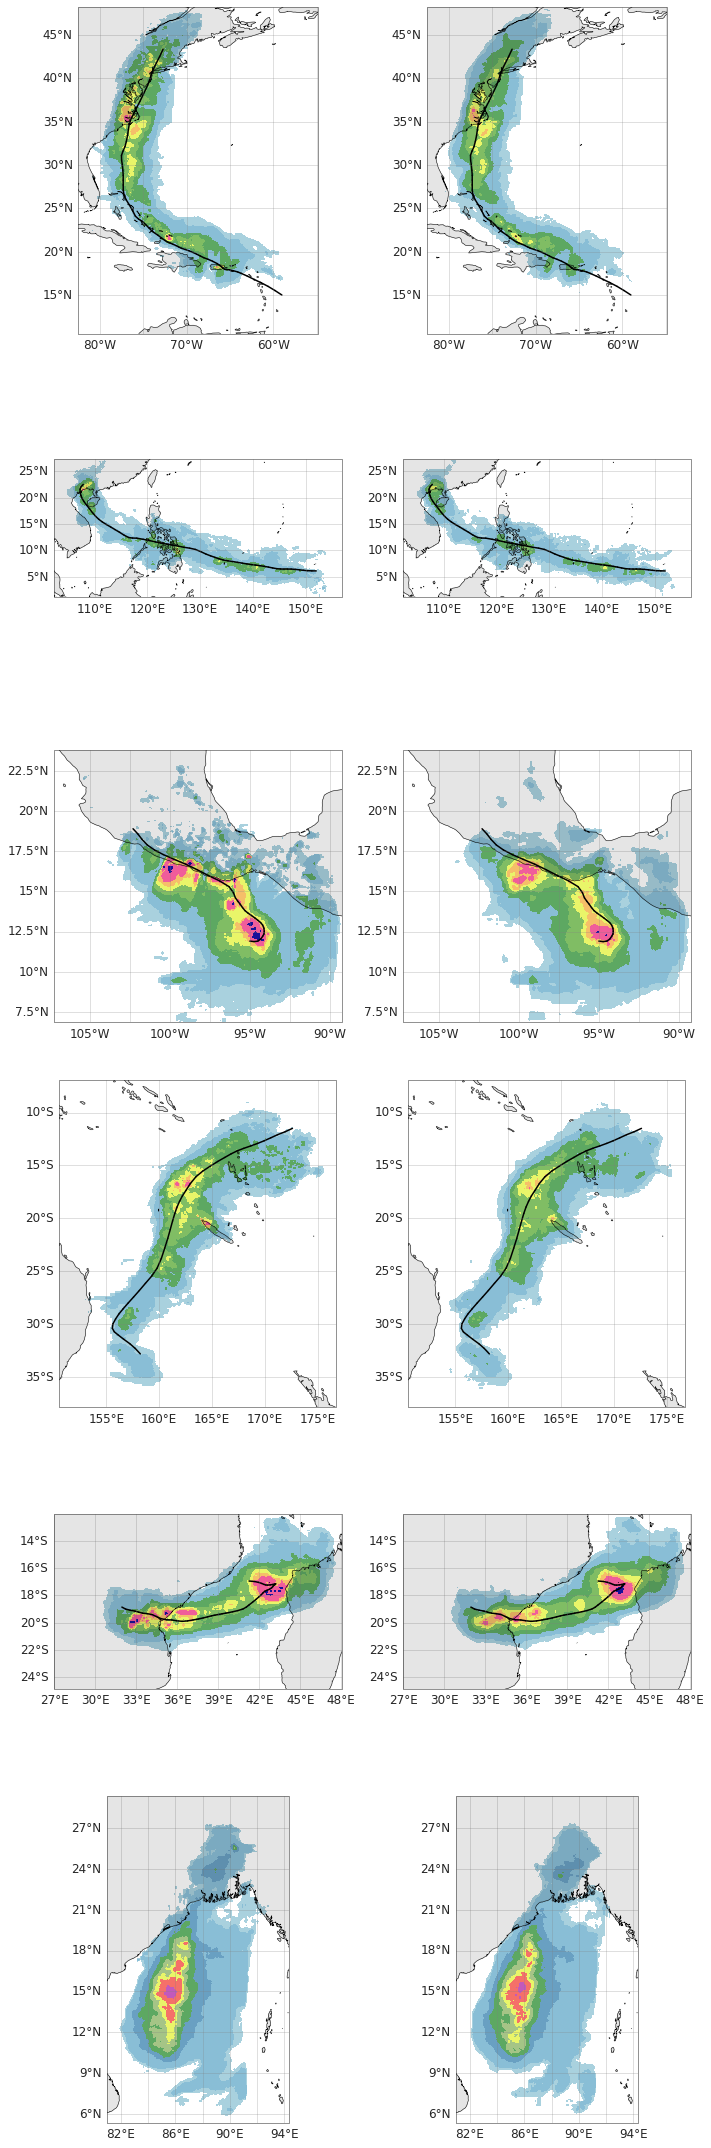

In [13]:
# set style
levels = [0,1,2,6,10,25,50,100,150,200,250,500]
# levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1,2,3,20,50]
levels = [0, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50,100,150,200,250,300,400,500]
sns.set_style("white")
sns.set_context("notebook")
# define cmap
precip_cmap,precip_norm = make_cmap(high_vals=True)
fig, axes = plt.subplots(6, 2, figsize=(10, 30), sharey=False,subplot_kw={'projection': ccrs.PlateCarree()})
# plot storm
axes[0,0] = plot_accumulated(accumulated_ds_1['precipitation'],accumulated_ds_1['lat'].values,accumulated_ds_1['lon'].values,vmin=0,vmax=500,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_1,centre_lons=centre_lons_1,intensity=intensity_1,ax=axes[0,0])
axes[0,1] = plot_accumulated(accumulated_ds_pred_1['precipitation'],accumulated_ds_pred_1['lat'].values,accumulated_ds_pred_1['lon'].values,vmin=0,vmax=500,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_1,centre_lons=centre_lons_1,intensity=intensity_1,ax=axes[0,1])

axes[1,0] = plot_accumulated(accumulated_ds_2['precipitation'],accumulated_ds_2['lat'].values,accumulated_ds_2['lon'].values,vmin=0,vmax=500,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_2,centre_lons=centre_lons_2,intensity=intensity_2,ax=axes[1,0])
axes[1,1] = plot_accumulated(accumulated_ds_pred_2['precipitation'],accumulated_ds_pred_2['lat'].values,accumulated_ds_pred_2['lon'].values,vmin=0,vmax=500,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_2,centre_lons=centre_lons_2,intensity=intensity_2,ax=axes[1,1])

axes[2,0] = plot_accumulated(accumulated_ds_3['precipitation'],accumulated_ds_3['lat'].values,accumulated_ds_3['lon'].values,vmin=0,vmax=500,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_3,centre_lons=centre_lons_3,intensity=intensity_3,ax=axes[2,0])
axes[2,1] = plot_accumulated(accumulated_ds_pred_3['precipitation'],accumulated_ds_pred_3['lat'].values,accumulated_ds_pred_3['lon'].values,vmin=0,vmax=500,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_3,centre_lons=centre_lons_3,intensity=intensity_3,ax=axes[2,1])

axes[3,0] = plot_accumulated(accumulated_ds_4['precipitation'],accumulated_ds_4['lat'].values,accumulated_ds_4['lon'].values,vmin=0,vmax=500,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_4,centre_lons=centre_lons_4,intensity=intensity_4,ax=axes[3,0])
axes[3,1] = plot_accumulated(accumulated_ds_pred_4['precipitation'],accumulated_ds_pred_4['lat'].values,accumulated_ds_pred_4['lon'].values,vmin=0,vmax=500,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_4,centre_lons=centre_lons_4,intensity=intensity_4,ax=axes[3,1])

axes[4,0] = plot_accumulated(accumulated_ds_5['precipitation'],accumulated_ds_5['lat'].values,accumulated_ds_5['lon'].values,vmin=0,vmax=500,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_5,centre_lons=centre_lons_5,intensity=intensity_5,ax=axes[4,0])
axes[4,1] = plot_accumulated(accumulated_ds_pred_5['precipitation'],accumulated_ds_pred_5['lat'].values,accumulated_ds_pred_5['lon'].values,vmin=0,vmax=500,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_5,centre_lons=centre_lons_5,intensity=intensity_5,ax=axes[4,1])

axes[5,0] = plot_accumulated(accumulated_ds_6['precipitation'],accumulated_ds_6['lat'].values,accumulated_ds_6['lon'].values,vmin=0,vmax=600,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_6,centre_lons=centre_lons_6,intensity=intensity_6,ax=axes[5,0])
axes[5,1] = plot_accumulated(accumulated_ds_pred_6['precipitation'],accumulated_ds_pred_6['lat'].values,accumulated_ds_pred_6['lon'].values,vmin=0,vmax=600,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_6,centre_lons=centre_lons_6,intensity=intensity_6,ax=axes[5,1])

plt.tight_layout()

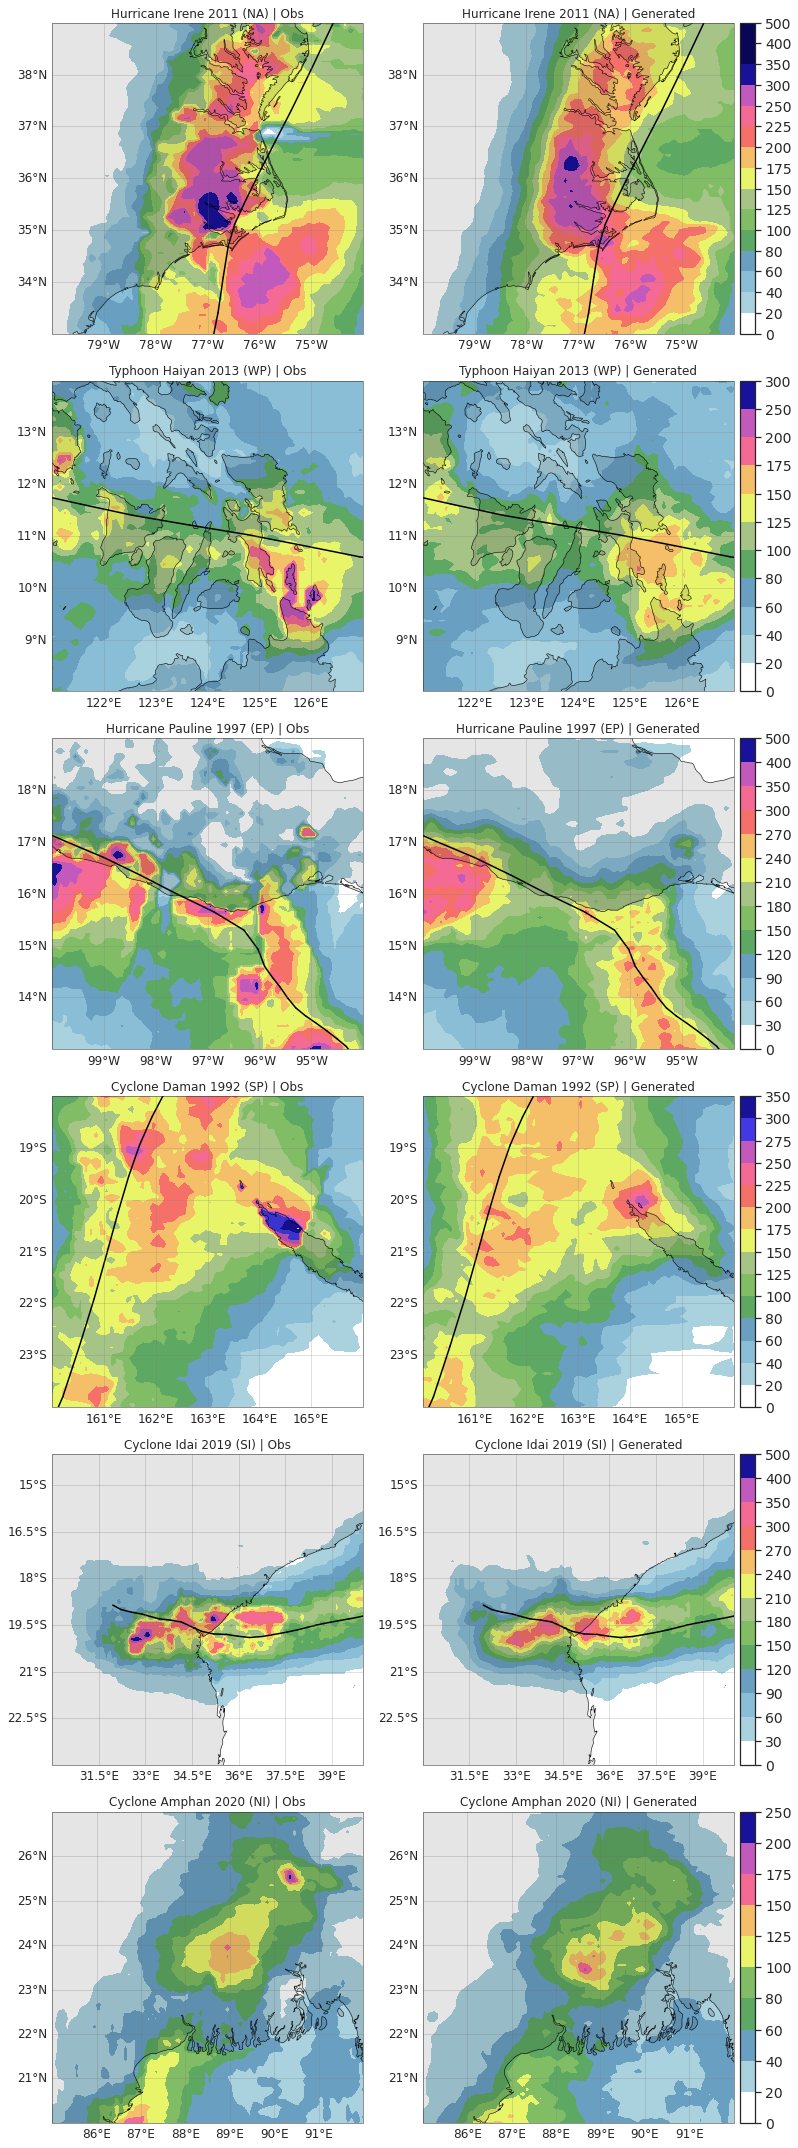

In [22]:

levels = [0, 1,2,3,4,6,10,15,20,25,40,50,100,150,200,250,300,350,400]
# levels = [0, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50]#100,150,200,250,300,350,400,500]
# levels = np.arange(0,500,10)
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,120,130, 150,180,200,250,300,350,400,450,500]
sns.set_style("white")
sns.set_context("notebook")
# define cmap
precip_cmap,precip_norm = make_cmap()

gridspec = {'width_ratios': [1,1, 0.2]}
fig, axes = plt.subplots(6, 3, figsize=(12, 30), sharey=False,subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw=gridspec)
axes[0, 2].axis('off')
axes[1, 2].axis('off')
axes[2, 2].axis('off')
axes[3, 2].axis('off')
axes[4, 2].axis('off')
axes[5, 2].axis('off')

extent_1 = [119, 22, 122, 25]
extent_2 = [-81, 33, -76, 39]
extent_3 = [-73, 16, -68, 21]

# Irene 2011233N15301 validation NA
xlim_1 = (-80,-74)
ylim_1 = (33,39)

# Haiyan 2013306N07162 validation WP
xlim_2 = (121,127)
ylim_2 = (8,14)

# Pauline 1997279N12263 extreme test EP
xlim_3 = (-100,-94)
ylim_3 = (13,19)

# Daman 1992044S09181 extreme valid SP (fiji)
xlim_4 = (160,166)
ylim_4 = (-24,-18)

# Idai 2019063S18038 train SI
xlim_5 = (30,40)
ylim_5 = (-24,-14)


# Amphan 2020136N10088 NI 2020138N10086
xlim_6 = (85,92)
ylim_6 = (20,27)

# Irene
levels = [0, 20, 25, 30, 40, 50, 70, 100, 125, 150, 175,200, 225, 250, 300, 350, 400, 500]
levels = [0, 20, 40, 60, 80, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400, 500]
title = 'Hurricane Irene 2011 (NA) | Obs'
axes[0,0] = plot_accumulated(accumulated_ds_1['precipitation'],accumulated_ds_1['lat'].values,accumulated_ds_1['lon'].values,
							vmin=0,vmax=350,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_1,
							centre_lons=centre_lons_1,intensity=intensity_1,ax=axes[0,0],mask_oceans=True,title=title)
title = 'Hurricane Irene 2011 (NA) | Generated'
axes[0,1] = plot_accumulated(accumulated_ds_pred_1['precipitation'],accumulated_ds_pred_1['lat'].values,accumulated_ds_pred_1['lon'].values,
							vmin=0,vmax=350,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_1,centre_lons=centre_lons_1,
							intensity=intensity_1,ax=axes[0,1],mask_oceans=True,title=title,cbar=True,cax=axes[0,2])
axes[0,0].set_xlim(xlim_1)
axes[0,0].set_ylim(ylim_1)
axes[0,1].set_xlim(xlim_1)
axes[0,1].set_ylim(ylim_1)

# Haiyan
# levels = [0,20, 25, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300]
levels = [0, 20, 40, 60, 80, 100, 125, 150, 175, 200, 250, 300]
title = 'Typhoon Haiyan 2013 (WP) | Obs'
axes[1,0] = plot_accumulated(accumulated_ds_2['precipitation'],accumulated_ds_2['lat'].values,
							accumulated_ds_2['lon'].values,vmin=0,vmax=300,cmap=precip_cmap,levels = levels,plot='ax',
							centre_lats=centre_lats_2,centre_lons=centre_lons_2,intensity=intensity_2,
							ax=axes[1,0],mask_oceans=True,title=title)
title = 'Typhoon Haiyan 2013 (WP) | Generated'
axes[1,1] = plot_accumulated(accumulated_ds_pred_2['precipitation'],accumulated_ds_pred_2['lat'].values,
							accumulated_ds_pred_2['lon'].values,vmin=0,vmax=300,cmap=precip_cmap,levels = levels,
							plot='ax',centre_lats=centre_lats_2,centre_lons=centre_lons_2,intensity=intensity_2,
							ax=axes[1,1],mask_oceans=True,title=title,cbar=True,cax=axes[1,2])
axes[1,0].set_xlim(xlim_2)
axes[1,0].set_ylim(ylim_2)
axes[1,1].set_xlim(xlim_2)
axes[1,1].set_ylim(ylim_2)

# Pauline
# levels = [0,20, 25, 30, 40, 50, 75, 100, 125, 150, 175, 200,250, 300, 350, 400, 500]
levels = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 350, 400, 500]

title = 'Hurricane Pauline 1997 (EP) | Obs'
axes[2,0] = plot_accumulated(accumulated_ds_3['precipitation'],accumulated_ds_3['lat'].values,
							accumulated_ds_3['lon'].values,vmin=0,vmax=500,cmap=precip_cmap,levels = levels,
							plot='ax',centre_lats=centre_lats_3,centre_lons=centre_lons_3,intensity=intensity_3,
							ax=axes[2,0],mask_oceans=True,title=title)
title = 'Hurricane Pauline 1997 (EP) | Generated'
axes[2,1] = plot_accumulated(accumulated_ds_pred_3['precipitation'],accumulated_ds_pred_3['lat'].values,
							accumulated_ds_pred_3['lon'].values,vmin=0,vmax=500,cmap=precip_cmap,levels = levels,
							plot='ax',centre_lats=centre_lats_3,centre_lons=centre_lons_3,intensity=intensity_3,
							ax=axes[2,1],mask_oceans=True,title=title,cbar=True,cax=axes[2,2])
axes[2,0].set_xlim(xlim_3)
axes[2,0].set_ylim(ylim_3)
axes[2,1].set_xlim(xlim_3)
axes[2,1].set_ylim(ylim_3)

# Daman
levels = [0,20, 40, 60, 80, 100, 125, 150, 175, 200, 225, 250, 275, 300, 350]
title = 'Cyclone Daman 1992 (SP) | Obs'
axes[3,0] = plot_accumulated(accumulated_ds_4['precipitation'],accumulated_ds_4['lat'].values,
							accumulated_ds_4['lon'].values,vmin=0,vmax=350,cmap=precip_cmap,levels = levels,
							plot='ax',centre_lats=centre_lats_4,centre_lons=centre_lons_4,intensity=intensity_4,
							ax=axes[3,0],mask_oceans=True,title=title)
title = 'Cyclone Daman 1992 (SP) | Generated'
axes[3,1] = plot_accumulated(accumulated_ds_pred_4['precipitation'],accumulated_ds_pred_4['lat'].values,
							accumulated_ds_pred_4['lon'].values,vmin=0,vmax=350,cmap=precip_cmap,levels = levels,
							plot='ax',centre_lats=centre_lats_4,centre_lons=centre_lons_4,intensity=intensity_4,
							ax=axes[3,1],mask_oceans=True,title=title,cbar=True,cax=axes[3,2])
axes[3,0].set_xlim(xlim_4)
axes[3,0].set_ylim(ylim_4)
axes[3,1].set_xlim(xlim_4)
axes[3,1].set_ylim(ylim_4)

# Idai
levels = [0,20, 25, 30, 40, 50, 75, 100, 125, 150, 175, 200,250, 300, 350, 400, 500]
levels = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 350, 400, 500]
title = 'Cyclone Idai 2019 (SI) | Obs'
axes[4,0] = plot_accumulated(accumulated_ds_5['precipitation'],accumulated_ds_5['lat'].values,
							accumulated_ds_5['lon'].values,vmin=0,vmax=500,cmap=precip_cmap,levels = levels,
							plot='ax',centre_lats=centre_lats_5,centre_lons=centre_lons_5,intensity=intensity_5,
							ax=axes[4,0],mask_oceans=True,title=title)
title = 'Cyclone Idai 2019 (SI) | Generated'
axes[4,1] = plot_accumulated(accumulated_ds_pred_5['precipitation'],accumulated_ds_pred_5['lat'].values,
							accumulated_ds_pred_5['lon'].values,vmin=0,vmax=500,cmap=precip_cmap,levels = levels,
							plot='ax',centre_lats=centre_lats_5,centre_lons=centre_lons_5,intensity=intensity_5,
							ax=axes[4,1],mask_oceans=True,title=title,cbar=True,cax=axes[4,2])
axes[4,0].set_xlim(xlim_5)
axes[4,0].set_ylim(ylim_5)
axes[4,1].set_xlim(xlim_5)
axes[4,1].set_ylim(ylim_5)

# Amphan
levels = levels = [0,20, 40, 60, 80, 100, 125, 150, 175, 200,250]
title = 'Cyclone Amphan 2020 (NI) | Obs'
axes[5,0] = plot_accumulated(accumulated_ds_6['precipitation'],accumulated_ds_6['lat'].values,
							accumulated_ds_6['lon'].values,vmin=0,vmax=250,cmap=precip_cmap,levels = levels,
							plot='ax',centre_lats=centre_lats_6,centre_lons=centre_lons_6,intensity=intensity_6,
							ax=axes[5,0],mask_oceans=True,title=title)
title = 'Cyclone Amphan 2020 (NI) | Generated'
axes[5,1] = plot_accumulated(accumulated_ds_pred_6['precipitation'],accumulated_ds_pred_6['lat'].values,
							accumulated_ds_pred_6['lon'].values,vmin=0,vmax=250,cmap=precip_cmap,levels = levels,
							plot='ax',centre_lats=centre_lats_6,centre_lons=centre_lons_6,intensity=intensity_6,
							ax=axes[5,1],mask_oceans=True,title=title,cbar=True,cax=axes[5,2])
axes[5,0].set_xlim(xlim_6)
axes[5,0].set_ylim(ylim_6)
axes[5,1].set_xlim(xlim_6)
axes[5,1].set_ylim(ylim_6)

plt.tight_layout()
plt.savefig('figure7-accumulated_rainfall.png',bbox_inches='tight')

In [15]:
# 2020138N10086

amphan = np.load('/user/work/al18709/tc_data_mswep_extend_flipped/X_2020348S14173.npy')
print(amphan.shape)

idai = np.load('/user/work/al18709/tc_Xy_extend/X_2001246N19156.npy')
print(idai.shape)



harvey = np.load('/user/work/al18709/tc_data_mswep_extend_flipped/y_2017228N14314.npy')

isaac = np.load('/user/work/al18709/tc_data_mswep_extend_flipped/y_2012234N16315.npy')

maria = np.load('/user/work/al18709/tc_data_mswep_extend_flipped/y_2017260N12310.npy')

irma = np.load('/user/work/al18709/tc_data_mswep_extend_flipped/y_2017242N16333.npy')
dorian = np.load('/user/work/al18709/tc_data_mswep_extend_flipped/y_2019236N10314.npy')


(52, 10, 10)
(65, 10, 10)


In [11]:
# amphan = np.load('/user/work/al18709/tc_data_mswep_extend/X_2020138N10086.npy')
# print(amphan.shape)

amphan = '/user/work/al18709/tropical_cyclones/mswep_extend/'

print(xr.load_dataset('/user/work/al18709/tropical_cyclones/mswep_extend/ZUMAN_1998087S15172_hour-9_idx-49156_cat-0_basin-SP_centrelat--20.4597_centrelon-165.542.nc'))

<xarray.Dataset>
Dimensions:        (x: 100, y: 100)
Coordinates:
  * x              (x) float32 160.6 160.7 160.8 160.9 ... 170.3 170.4 170.4
  * y              (y) float32 -25.45 -25.35 -25.25 ... -15.75 -15.65 -15.55
Data variables:
    precipitation  (x, y) float32 0.0625 0.0625 0.0625 0.0625 ... 0.0 0.0 0.0625


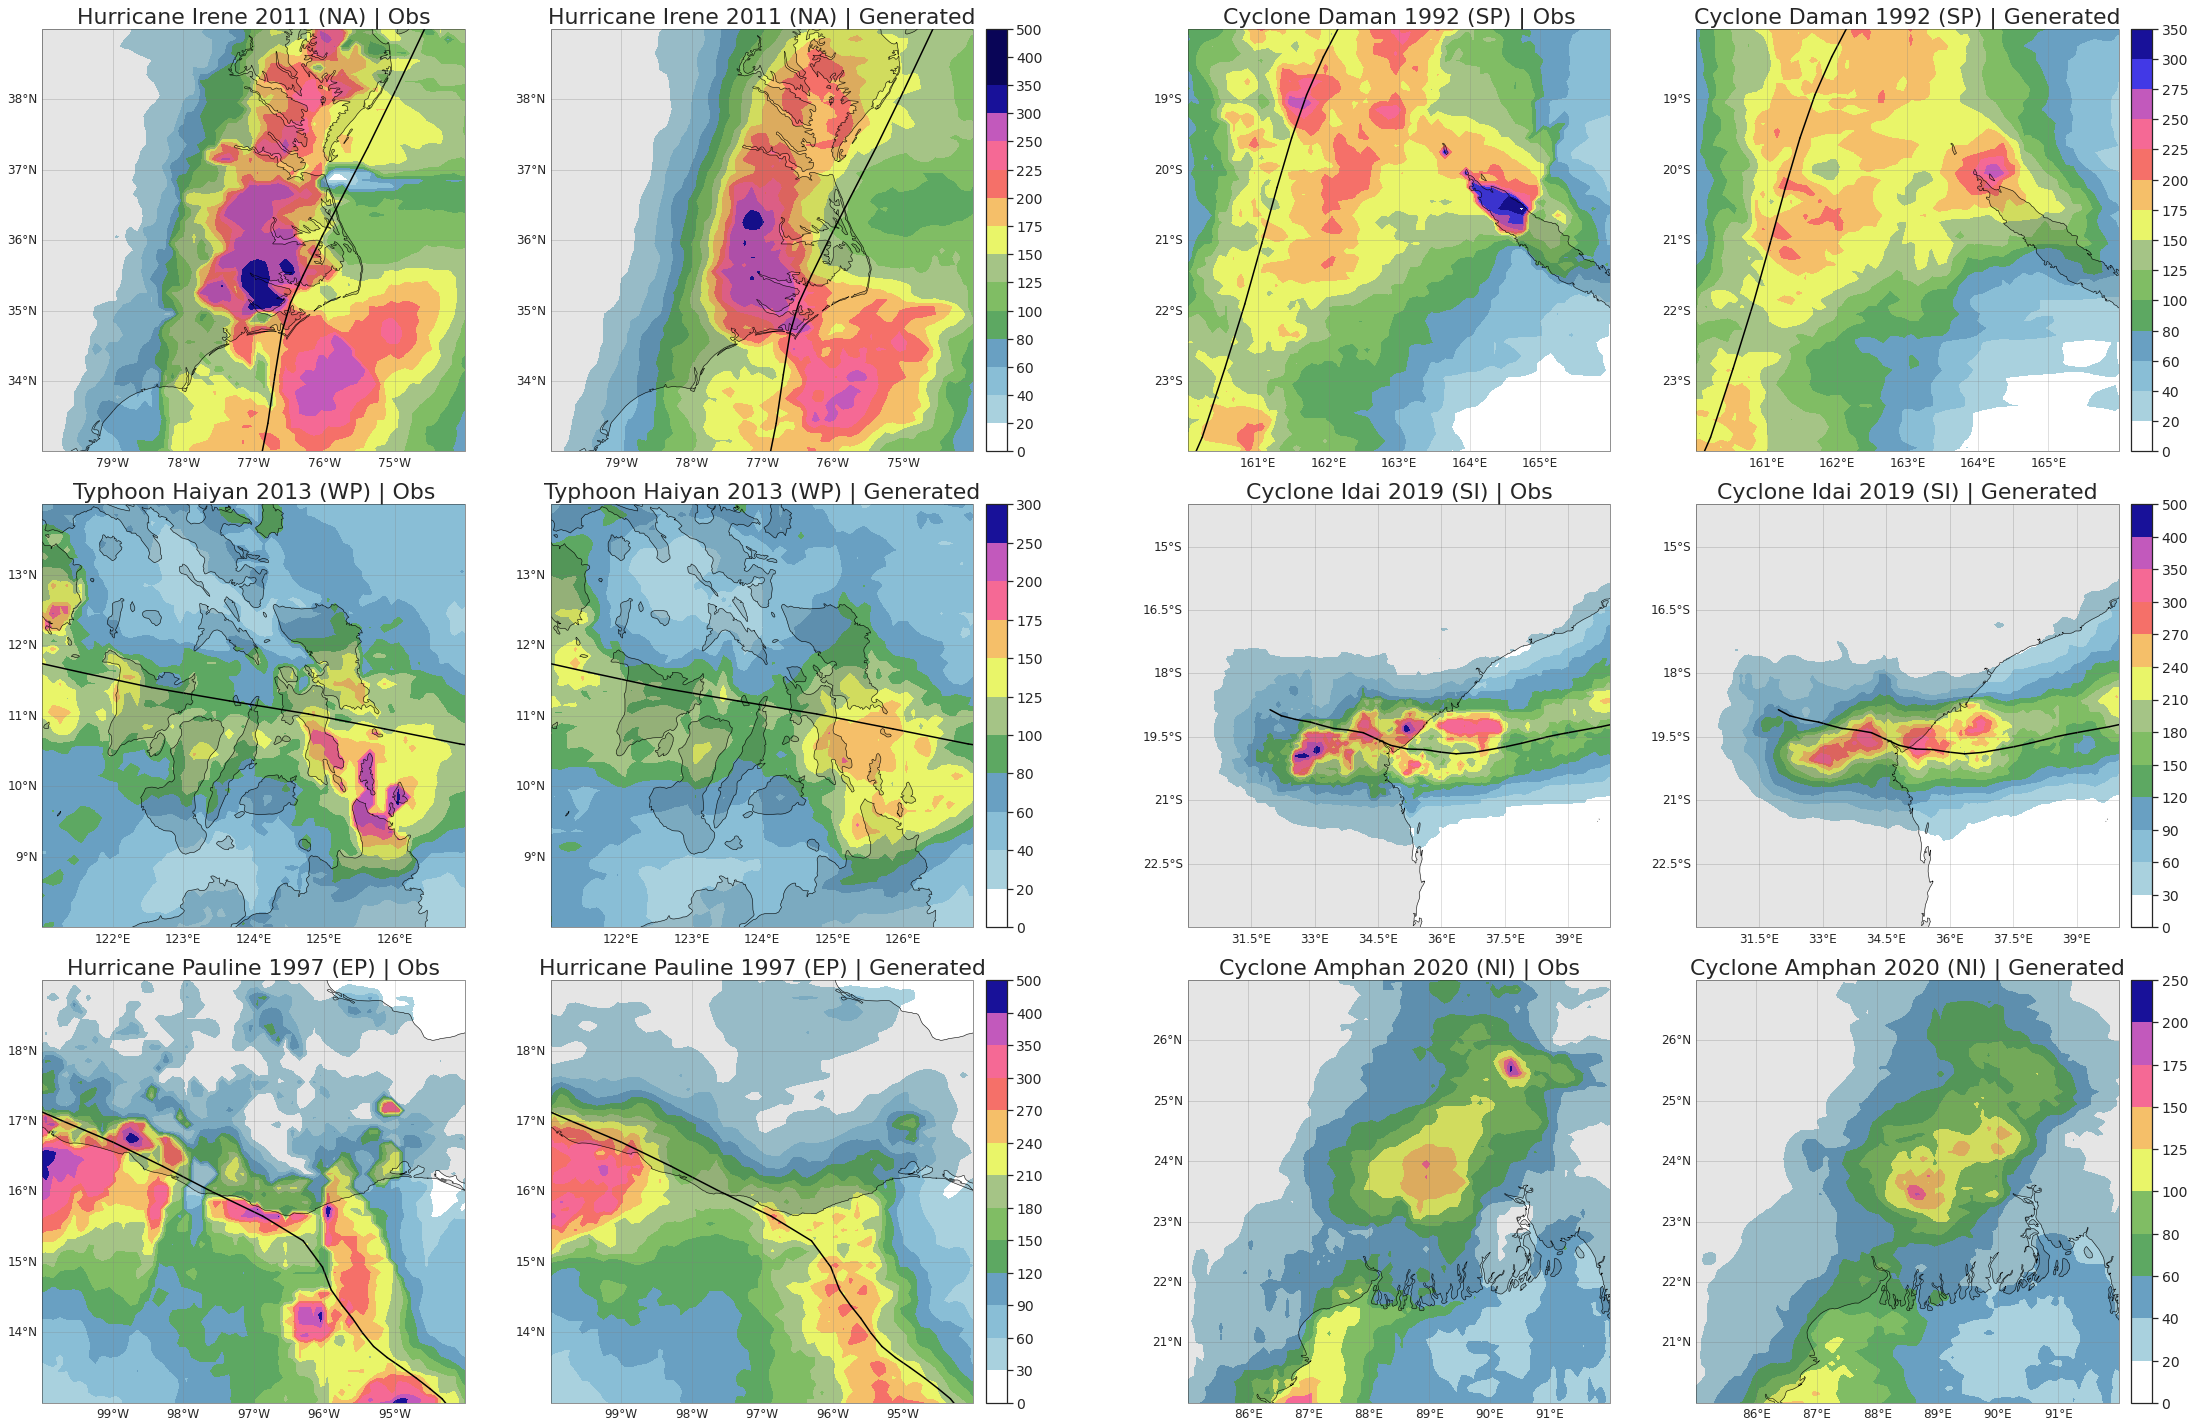

In [31]:
levels = [0, 1,2,3,4,6,10,15,20,25,40,50,100,150,200,250,300,350,400]
# levels = [0, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50]#100,150,200,250,300,350,400,500]
# levels = np.arange(0,500,10)
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,120,130, 150,180,200,250,300,350,400,450,500]
sns.set_style("white")
sns.set_context("notebook")
# define cmap
precip_cmap,precip_norm = make_cmap()

gridspec = {'width_ratios': [1,1,0.2,1,1, 0.2]}
fig, axes = plt.subplots(3, 6, figsize=(32, 20), sharey=False,subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw=gridspec)
axes[0, 5].axis('off')
axes[1, 5].axis('off')
axes[2, 5].axis('off')
# axes[3, 5].axis('off')
axes[0, 2].axis('off')
axes[1, 2].axis('off')
axes[2, 2].axis('off')
# axes[3, 2].axis('off')

extent_1 = [119, 22, 122, 25]
extent_2 = [-81, 33, -76, 39]
extent_3 = [-73, 16, -68, 21]

# Irene 2011233N15301 validation NA
xlim_1 = (-80,-74)
ylim_1 = (33,39)

# Haiyan 2013306N07162 validation WP
xlim_2 = (121,127)
ylim_2 = (8,14)

# Pauline 1997279N12263 extreme test EP
xlim_3 = (-100,-94)
ylim_3 = (13,19)

# Daman 1992044S09181 extreme valid SP (fiji)
xlim_4 = (160,166)
ylim_4 = (-24,-18)

# Idai 2019063S18038 train SI
xlim_5 = (30,40)
ylim_5 = (-24,-14)


# Amphan 2020136N10088 NI 2020138N10086
xlim_6 = (85,92)
ylim_6 = (20,27)

# Irene
levels = [0, 20, 25, 30, 40, 50, 70, 100, 125, 150, 175,200, 225, 250, 300, 350, 400, 500]
levels = [0, 20, 40, 60, 80, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400, 500]
title = 'Hurricane Irene 2011 (NA) | Obs'
axes[0,0] = plot_accumulated(accumulated_ds_1['precipitation'],accumulated_ds_1['lat'].values,accumulated_ds_1['lon'].values,
							vmin=0,vmax=350,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_1,
							centre_lons=centre_lons_1,intensity=intensity_1,ax=axes[0,0],mask_oceans=True,title=title)
title = 'Hurricane Irene 2011 (NA) | Generated'
axes[0,1] = plot_accumulated(accumulated_ds_pred_1['precipitation'],accumulated_ds_pred_1['lat'].values,accumulated_ds_pred_1['lon'].values,
							vmin=0,vmax=350,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_1,centre_lons=centre_lons_1,
							intensity=intensity_1,ax=axes[0,1],mask_oceans=True,title=title,cbar=True,cax=axes[0,2])
axes[0,0].set_xlim(xlim_1)
axes[0,0].set_ylim(ylim_1)
axes[0,1].set_xlim(xlim_1)
axes[0,1].set_ylim(ylim_1)

# Haiyan
# levels = [0,20, 25, 30, 40, 50, 75, 100, 125, 150, 175, 200, 250, 300]
levels = [0, 20, 40, 60, 80, 100, 125, 150, 175, 200, 250, 300]
title = 'Typhoon Haiyan 2013 (WP) | Obs'
axes[1,0] = plot_accumulated(accumulated_ds_2['precipitation'],accumulated_ds_2['lat'].values,
							accumulated_ds_2['lon'].values,vmin=0,vmax=300,cmap=precip_cmap,levels = levels,plot='ax',
							centre_lats=centre_lats_2,centre_lons=centre_lons_2,intensity=intensity_2,
							ax=axes[1,0],mask_oceans=True,title=title)
title = 'Typhoon Haiyan 2013 (WP) | Generated'
axes[1,1] = plot_accumulated(accumulated_ds_pred_2['precipitation'],accumulated_ds_pred_2['lat'].values,
							accumulated_ds_pred_2['lon'].values,vmin=0,vmax=300,cmap=precip_cmap,levels = levels,
							plot='ax',centre_lats=centre_lats_2,centre_lons=centre_lons_2,intensity=intensity_2,
							ax=axes[1,1],mask_oceans=True,title=title,cbar=True,cax=axes[1,2])
axes[1,0].set_xlim(xlim_2)
axes[1,0].set_ylim(ylim_2)
axes[1,1].set_xlim(xlim_2)
axes[1,1].set_ylim(ylim_2)

# Pauline
# levels = [0,20, 25, 30, 40, 50, 75, 100, 125, 150, 175, 200,250, 300, 350, 400, 500]
levels = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 350, 400, 500]

title = 'Hurricane Pauline 1997 (EP) | Obs'
axes[2,0] = plot_accumulated(accumulated_ds_3['precipitation'],accumulated_ds_3['lat'].values,
							accumulated_ds_3['lon'].values,vmin=0,vmax=500,cmap=precip_cmap,levels = levels,
							plot='ax',centre_lats=centre_lats_3,centre_lons=centre_lons_3,intensity=intensity_3,
							ax=axes[2,0],mask_oceans=True,title=title)
title = 'Hurricane Pauline 1997 (EP) | Generated'
axes[2,1] = plot_accumulated(accumulated_ds_pred_3['precipitation'],accumulated_ds_pred_3['lat'].values,
							accumulated_ds_pred_3['lon'].values,vmin=0,vmax=500,cmap=precip_cmap,levels = levels,
							plot='ax',centre_lats=centre_lats_3,centre_lons=centre_lons_3,intensity=intensity_3,
							ax=axes[2,1],mask_oceans=True,title=title,cbar=True,cax=axes[2,2])
axes[2,0].set_xlim(xlim_3)
axes[2,0].set_ylim(ylim_3)
axes[2,1].set_xlim(xlim_3)
axes[2,1].set_ylim(ylim_3)

# Daman
levels = [0,20, 40, 60, 80, 100, 125, 150, 175, 200, 225, 250, 275, 300, 350]
title = 'Cyclone Daman 1992 (SP) | Obs'
axes[0,3] = plot_accumulated(accumulated_ds_4['precipitation'],accumulated_ds_4['lat'].values,
							accumulated_ds_4['lon'].values,vmin=0,vmax=350,cmap=precip_cmap,levels = levels,
							plot='ax',centre_lats=centre_lats_4,centre_lons=centre_lons_4,intensity=intensity_4,
							ax=axes[0,3],mask_oceans=True,title=title)
title = 'Cyclone Daman 1992 (SP) | Generated'
axes[0,4] = plot_accumulated(accumulated_ds_pred_4['precipitation'],accumulated_ds_pred_4['lat'].values,
							accumulated_ds_pred_4['lon'].values,vmin=0,vmax=350,cmap=precip_cmap,levels = levels,
							plot='ax',centre_lats=centre_lats_4,centre_lons=centre_lons_4,intensity=intensity_4,
							ax=axes[0,4],mask_oceans=True,title=title,cbar=True,cax=axes[0,5])
axes[0,3].set_xlim(xlim_4)
axes[0,3].set_ylim(ylim_4)
axes[0,4].set_xlim(xlim_4)
axes[0,4].set_ylim(ylim_4)

# Idai
levels = [0,20, 25, 30, 40, 50, 75, 100, 125, 150, 175, 200,250, 300, 350, 400, 500]
levels = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 350, 400, 500]
title = 'Cyclone Idai 2019 (SI) | Obs'
axes[1,3] = plot_accumulated(accumulated_ds_5['precipitation'],accumulated_ds_5['lat'].values,
							accumulated_ds_5['lon'].values,vmin=0,vmax=500,cmap=precip_cmap,levels = levels,
							plot='ax',centre_lats=centre_lats_5,centre_lons=centre_lons_5,intensity=intensity_5,
							ax=axes[1,3],mask_oceans=True,title=title)
title = 'Cyclone Idai 2019 (SI) | Generated'
axes[1,4] = plot_accumulated(accumulated_ds_pred_5['precipitation'],accumulated_ds_pred_5['lat'].values,
							accumulated_ds_pred_5['lon'].values,vmin=0,vmax=500,cmap=precip_cmap,levels = levels,
							plot='ax',centre_lats=centre_lats_5,centre_lons=centre_lons_5,intensity=intensity_5,
							ax=axes[1,4],mask_oceans=True,title=title,cbar=True,cax=axes[1,5])
axes[1,3].set_xlim(xlim_5)
axes[1,3].set_ylim(ylim_5)
axes[1,4].set_xlim(xlim_5)
axes[1,4].set_ylim(ylim_5)

# Amphan
levels = levels = [0,20, 40, 60, 80, 100, 125, 150, 175, 200,250]
title = 'Cyclone Amphan 2020 (NI) | Obs'
axes[2,3] = plot_accumulated(accumulated_ds_6['precipitation'],accumulated_ds_6['lat'].values,
							accumulated_ds_6['lon'].values,vmin=0,vmax=250,cmap=precip_cmap,levels = levels,
							plot='ax',centre_lats=centre_lats_6,centre_lons=centre_lons_6,intensity=intensity_6,
							ax=axes[2,3],mask_oceans=True,title=title)
title = 'Cyclone Amphan 2020 (NI) | Generated'
axes[2,4] = plot_accumulated(accumulated_ds_pred_6['precipitation'],accumulated_ds_pred_6['lat'].values,
							accumulated_ds_pred_6['lon'].values,vmin=0,vmax=250,cmap=precip_cmap,levels = levels,
							plot='ax',centre_lats=centre_lats_6,centre_lons=centre_lons_6,intensity=intensity_6,
							ax=axes[2,4],mask_oceans=True,title=title,cbar=True,cax=axes[2,5])
axes[2,3].set_xlim(xlim_6)
axes[2,3].set_ylim(ylim_6)
axes[2,4].set_xlim(xlim_6)
axes[2,4].set_ylim(ylim_6)

plt.tight_layout()
plt.savefig('figure7-accumulated_rainfall.png',bbox_inches='tight')